In [15]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import re
from sklearn.metrics import f1_score
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm
import rasterio
import torchvision.transforms as T

# from torchsummary import summary
from torchinfo import summary

## Preprocess

### Invert Labels

In [2]:
folder_path = 'original_labels/Abs Train Label Images'
output_path = 'QBAM_DNNS/Abs Train Label Images'

for filename in os.listdir(folder_path):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        with rasterio.open(folder_path + '/' + filename) as file:
            image_data = file.read(1)

        for i in range(image_data.shape[0]):
            for j in range(image_data.shape[1]):
                if image_data[i, j] < 3.5:
                    image_data[i, j] = 255
                elif image_data[i, j] > 3.5:
                    image_data[i, j] = 0

        with rasterio.open(output_path + '/' + filename, 'w', **file.meta) as dst:
            dst.write(image_data, 1)

/Users/matt/Brown/Lab/dnns/.venv/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/matt/Brown/Lab/dnns/.venv/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


## Setup

### Make sure packages are installed

In [3]:
directory_path = 'QBAM_DNNS'

# Check if the directory exists
if os.path.exists(directory_path):
    # List contents of the directory
    directory_contents = os.listdir(directory_path)
    print(f"Contents of '{directory_path}':")
    for item in directory_contents:
        print(item)
else:
    print(f"The directory {directory_path} does not exist.")

Contents of 'QBAM_DNNS':
.DS_Store
Abs Test Images
Abs Train Images
Abs Test Label Images
Abs Train Label Images


### Check CUDA

In [4]:
print(torch.__version__)
print(torch.version.cuda)

print("Is MPS even available?:", torch.backends.mps.is_available())
print("Is the current version of PyTorch built with MPS activated?:", torch.backends.mps.is_built())

2.2.0
None
Is MPS even available?: True
Is the current version of PyTorch built with MPS activated?: True


In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {device} device")

Using mps device


### Check dataset

In [6]:
train_dir_path = 'QBAM_DNNS/Abs Train Images'
train_label_dir_path = 'QBAM_DNNS/Abs Train Label Images'

test_dir_path = 'QBAM_DNNS/Abs Test Images'
test_label_dir_path = 'QBAM_DNNS/Abs Test Label Images'

train_count = 0
train_label_count = 0

test_count = 0
test_label_count = 0

for path in os.listdir(train_dir_path):
    if os.path.isfile(os.path.join(train_dir_path, path)):
        train_count += 1

for path in os.listdir(train_label_dir_path):
    if os.path.isfile(os.path.join(train_label_dir_path, path)):
        train_label_count += 1

for path in os.listdir(test_dir_path):
    if os.path.isfile(os.path.join(test_dir_path, path)):
        test_count += 1

for path in os.listdir(test_label_dir_path):
    if os.path.isfile(os.path.join(test_label_dir_path, path)):
        test_label_count += 1


print('Train images count:', train_count, 'Train Labels count:', train_label_count)
print('Test images count:', test_count, 'Test Labels count:', test_label_count)


Train images count: 929 Train Labels count: 929
Test images count: 103 Test Labels count: 103


(256, 256, 1)
(256, 256, 1)


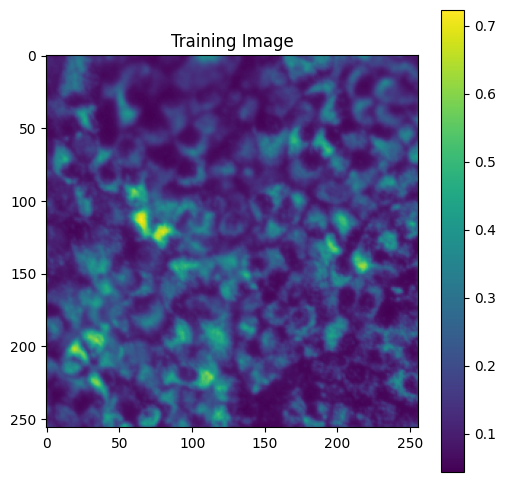

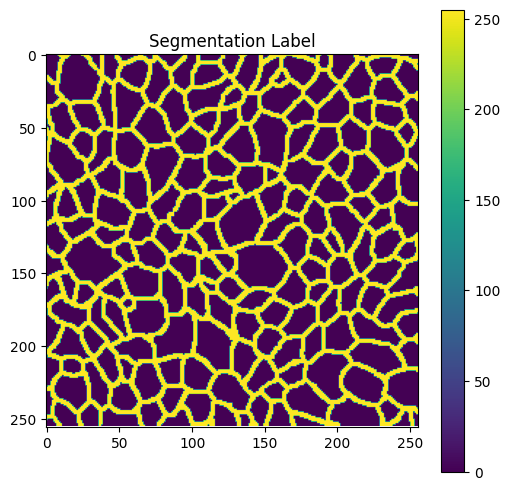

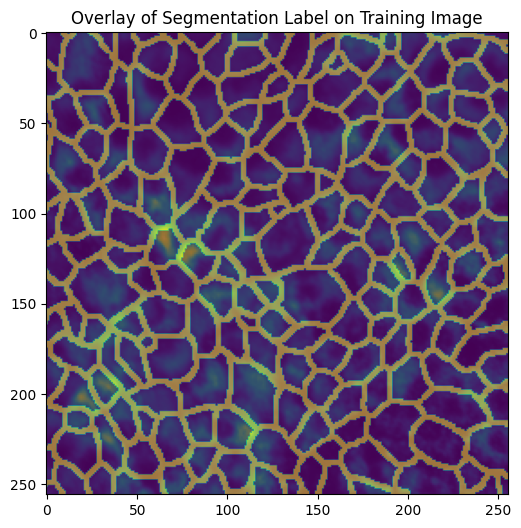

In [7]:
image_path = 'QBAM_DNNS/Abs Train Images/AMD1_Clone-A_D75_n1095_r2178_c213.tif'
label_path = 'QBAM_DNNS/Abs Train Label Images/AMD1_Clone-A_D75_n1095_r2201_c201.tif'
#label_path = 'original_labels/Abs Train Label Images/AMD1_Clone-A_D75_n1095_r2201_c201.tif'

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

image = tiff.imread(image_path)
label = tiff.imread(label_path)

image = rgb2gray(image)

image = np.array(image)
image = np.expand_dims(image, axis=2)
label = np.array(label)
label = np.expand_dims(label, axis=2)

print(image.shape)
print(label.shape)

# Display the training image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.colorbar()
plt.title('Training Image')

# Display the label image
plt.figure(figsize=(6, 6))
plt.imshow(label)  
plt.colorbar()
plt.title('Segmentation Label')

### Overlaying the Segmentation Label on the Training Image
plt.figure(figsize=(6, 6)) 
plt.imshow(image)
plt.imshow(label, alpha=0.5)
plt.title('Overlay of Segmentation Label on Training Image')
plt.savefig("example.png")
plt.show()


## Model

### Model Architecture

In [19]:
class InceptionLayer(nn.Module):
    def __init__(self,
                 in_channels,
                 c_1x1,
                 c_3x3_reduce,
                 c_3x3,
                 c_5x5_reduce,
                 c_5x5,
                 pool_projection,
                 is_left = False):

        super(InceptionLayer, self).__init__()

        # 1x1 conv branch
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, c_1x1, kernel_size=1),
            nn.ReLU()
        )

        # 1x1 conv -> 3x3 conv branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, c_3x3_reduce, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(c_3x3_reduce, c_3x3, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, c_5x5_reduce, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(c_5x5_reduce, c_5x5, kernel_size=5, padding=2),
            nn.ReLU()
        )

        # 3x3 pool -> 1x1 conv branch
        if is_left:
            self.branch_pool = nn.Sequential(
                nn.Conv2d(in_channels, pool_projection, kernel_size=1),
                nn.ReLU()
            )
        else:
            self.branch_pool = nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                nn.Conv2d(in_channels, pool_projection, kernel_size=1),
                nn.ReLU()
            )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)

        branch_pool = self.branch_pool(x)
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]

        return torch.cat(outputs, 1)

class SegmentModel(nn.Module):
    def __init__(self):
      super(SegmentModel, self).__init__()
      self.relu = nn.ReLU()


      self.inception1a = InceptionLayer(in_channels=1,
                                        c_1x1=16,
                                        c_3x3_reduce=16,
                                        c_3x3=16,
                                        c_5x5_reduce=8,
                                        c_5x5=8,
                                        pool_projection=24,
                                        is_left=True)

      self.inception1b = InceptionLayer(64, 16, 16, 16, 8, 8, 24, True)

      self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      self.inception2 = InceptionLayer(64, 32, 32, 32, 16, 16, 48, True)

      self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      self.inception3 = InceptionLayer(128, 64, 64, 64, 32, 32, 96, True)

      self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      self.inception4 = InceptionLayer(256, 128, 128, 128, 64, 64, 192, True)

      self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      self.inception5a = InceptionLayer(512, 128, 128, 128, 64, 64, 192)
      self.inception5b = InceptionLayer(512, 128, 128, 128, 64, 64, 192)
      self.inception5c = InceptionLayer(512, 128, 128, 128, 64, 64, 192)
      self.convTrans1 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2, padding=0)

      self.inception6 = InceptionLayer(1024, 128, 128, 128, 64, 64, 192)
      self.convTrans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0)

      self.inception7 = InceptionLayer(512, 64, 64, 64, 32, 32, 96)
      self.convTrans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)

      self.inception8 = InceptionLayer(256, 32, 16, 32, 16, 32, 32)
      self.convTrans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)

      self.inception9 = InceptionLayer(128, 32, 32, 32, 16, 16, 48)

      self.dropout = nn.Dropout(0.5)
      self.final_conv = nn.Conv2d(128, 1, kernel_size=7, padding=3)

    def forward(self, x):
        x = self.inception1a(x)
        il_1b = self.inception1b(x)
        x = self.maxpool1(il_1b)
        il_2 = self.inception2(x)
        x = self.maxpool2(il_2)
        il_3 = self.inception3(x)
        x = self.maxpool3(il_3)
        il_4 = self.inception4(x)
        x = self.maxpool4(il_4)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.inception5c(x)
        x = self.convTrans1(x)
        x = self.relu(x)


        x = torch.cat([x, il_4], 1)
        x = self.inception6(x)
        x = self.convTrans2(x)
        x = self.relu(x)

        x = torch.cat([x, il_3], 1)
        x = self.inception7(x)
        x = self.convTrans3(x)
        x = self.relu(x)

        x = torch.cat([x, il_2], 1)
        x = self.inception8(x)
        x = self.convTrans4(x)
        x = self.relu(x)

        x = torch.cat([x, il_1b], 1)
        x = self.inception9(x)

        x = self.dropout(x)
        x = self.final_conv(x)

        return x

# class SegmentModel(nn.Module):
#     def __init__(self):
#         super(SegmentModel, self).__init__()
#         self.relu = nn.ReLU()

#         self.inception1a = InceptionLayer(in_channels=1, c_1x1=16, c_3x3_reduce=16, c_3x3=16, c_5x5_reduce=8, c_5x5=8, pool_projection=24, is_left=True)
#         self.inception1b = InceptionLayer(64, 16, 16, 16, 8, 8, 24, True)
        
#         self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.inception2 = InceptionLayer(64, 32, 32, 32, 16, 16, 48, True)
        
#         self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.inception3 = InceptionLayer(128, 64, 64, 64, 32, 32, 96, True)
        
#         self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.inception4 = InceptionLayer(256, 128, 128, 128, 64, 64, 192, True)
        
#         self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.inception5a = InceptionLayer(512, 128, 128, 128, 64, 64, 192)
#         self.inception5b = InceptionLayer(512, 128, 128, 128, 64, 64, 192)
#         self.inception5c = InceptionLayer(512, 128, 128, 128, 64, 64, 192)
#         self.convTrans1 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2, padding=0)
        
#         self.inception6 = InceptionLayer(1024, 128, 128, 128, 64, 64, 192)
#         self.convTrans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0)
        
#         self.inception7 = InceptionLayer(512, 64, 64, 64, 32, 32, 96)
#         self.convTrans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)
        
#         self.inception8 = InceptionLayer(256, 32, 16, 32, 16, 32, 32)
#         self.convTrans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)
        
#         self.inception9 = InceptionLayer(128, 32, 32, 32, 16, 16, 48)
        
#         self.dropout = nn.Dropout(0.5)
#         self.final_conv = nn.Conv2d(128, 1, kernel_size=57, padding=0)  # Adjust kernel_size to reduce dimensions
        
#     def forward(self, x):
#         x = self.inception1a(x)
#         il_1b = self.inception1b(x)
#         x = self.maxpool1(il_1b)
#         il_2 = self.inception2(x)
#         x = self.maxpool2(il_2)
#         il_3 = self.inception3(x)
#         x = self.maxpool3(il_3)
#         il_4 = self.inception4(x)
#         x = self.maxpool4(il_4)
#         x = self.inception5a(x)
#         x = self.inception5b(x)
#         x = self.inception5c(x)
#         x = self.convTrans1(x)
#         x = self.relu(x)
        
#         x = torch.cat([x, il_4], 1)
#         x = self.inception6(x)
#         x = self.convTrans2(x)
#         x = self.relu(x)
        
#         x = torch.cat([x, il_3], 1)
#         x = self.inception7(x)
#         x = self.convTrans3(x)
#         x = self.relu(x)
        
#         x = torch.cat([x, il_2], 1)
#         x = self.inception8(x)
#         x = self.convTrans4(x)
#         x = self.relu(x)
        
#         x = torch.cat([x, il_1b], 1)
#         x = self.inception9(x)
        
#         x = self.dropout(x)
#         x = self.final_conv(x)
#         print(x.shape)
#         return x


### Custom Loss function (based on log loss)

In [20]:
class CustomLogLoss(nn.Module):
    def __init__(self):
        super(CustomLogLoss, self).__init__()

    def forward(self, x, c):
        B = torch.clamp(-c * x, min=0)
        loss = B + torch.log(torch.exp(B) + torch.exp(-c * x))
        return loss.mean()

### Define Dataset and DataLoader

In [21]:
from torchvision.transforms.functional import to_pil_image

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.pairs = self._find_pairs(images_dir, labels_dir)
        self.save_pairs('Examples')

    def _find_pairs(self, images_dir, labels_dir):
        pairs = {}
        pattern = re.compile(r'(_n\d+_)')

        image_files = os.listdir(images_dir)
        label_files = os.listdir(labels_dir)

        label_dict = {}
        for label_name in label_files:
            match = pattern.search(label_name)
            if match:
                label_unique_id = match.group(1)  
                label_dict[label_unique_id] = label_name

        for image_name in image_files:
            match = pattern.search(image_name)
            if match:
                image_unique_id = match.group(1)
                if image_unique_id in label_dict:
                    label_name = label_dict[image_unique_id]
                    pairs[image_unique_id] = (os.path.join(images_dir, image_name),
                                              os.path.join(labels_dir, label_name))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        unique_id = list(self.pairs.keys())[idx]
        image_path, label_path = self.pairs[unique_id]

        image = tiff.imread(image_path)
        label = tiff.imread(label_path)

        image = rgb2gray(image)
        image = np.array(image)
        image = np.expand_dims(image, axis=2)
        label = np.array(label)
        label = np.expand_dims(label, axis=2)
        
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label
    
    def save_pairs(self, save_dir):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        for idx, (unique_id, (image_path, label_path)) in enumerate(self.pairs.items()):
            image, label = self.__getitem__(idx)
            
            if not isinstance(image, Image.Image):
                image = to_pil_image(image)
            if not isinstance(label, Image.Image):
                label = to_pil_image(label)
            
            # Combine the image and label side by side
            combined_image = Image.new('RGB', (image.width + label.width, image.height))
            combined_image.paste(image, (0, 0))
            combined_image.paste(label, (image.width, 0))
            
            combined_save_path = os.path.join(save_dir, f'combined_{unique_id.strip("_")}.png')
            combined_image.save(combined_save_path)

        print(f"Saved {len(self)} combined pairs of images and labels to {save_dir}")

In [35]:
images_dir = 'QBAM_DNNS/Abs Train Images'
labels_dir = 'QBAM_DNNS/Abs Train Label Images'

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = SegmentationDataset(images_dir=images_dir, labels_dir=labels_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

Saved 929 combined pairs of images and labels to Examples


### Initialize Model, Loss Function, and Optimizer

In [36]:
model = SegmentModel()
loss_fn = CustomLogLoss()
optimizer = optim.Adadelta(model.parameters(), rho=0.9, eps=0.000001, lr=0.001)

summary(model, input_size=(10, 1, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
SegmentModel                             [10, 1, 256, 256]         --
├─InceptionLayer: 1-1                    [10, 64, 256, 256]        --
│    └─Sequential: 2-1                   [10, 16, 256, 256]        --
│    │    └─Conv2d: 3-1                  [10, 16, 256, 256]        32
│    │    └─ReLU: 3-2                    [10, 16, 256, 256]        --
│    └─Sequential: 2-2                   [10, 16, 256, 256]        --
│    │    └─Conv2d: 3-3                  [10, 16, 256, 256]        32
│    │    └─ReLU: 3-4                    [10, 16, 256, 256]        --
│    │    └─Conv2d: 3-5                  [10, 16, 256, 256]        2,320
│    │    └─ReLU: 3-6                    [10, 16, 256, 256]        --
│    └─Sequential: 2-3                   [10, 8, 256, 256]         --
│    │    └─Conv2d: 3-7                  [10, 8, 256, 256]         16
│    │    └─ReLU: 3-8                    [10, 8, 256, 256]         --
│    │    └─

## Running Model

### Train

In [37]:
model = model.to(device)

num_epochs = 25
best_f1 = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    train_loader_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

    for batch in train_loader_progress:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        
        train_loader_progress.set_postfix(loss=f'{loss.item():.4f}')

    # Evaluation for this epoch
    model.eval()
    all_labels = []
    all_predictions = []
    
    printed_once = False
    with torch.no_grad():
        for batch in tqdm(train_loader, desc='Evaluating', leave=False, unit='batch'):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            probabilities = torch.sigmoid(outputs)

            predictions = (probabilities > 0.5).float()
            predictions = predictions.int()

            # if not printed_once:
            #     plt.imshow(image)
            #     plt.show()
            #     plt.imshow(label)
            #     plt.show()
            #     transform = T.ToPILImage()
            #     img = transform(outputs[0])
            #     img.show()
            #     printed_once = True

            labels_flat = labels.view(-1).int().cpu().numpy()
            predictions_flat = predictions.view(-1).cpu().numpy()

            all_labels.extend(labels_flat)
            all_predictions.extend(predictions_flat)

    # Now calculate the f1 score
    f1 = f1_score(all_labels, all_predictions)
    print(f'Epoch {epoch}, F1 Score: {f1:.4f}')

    # Save the best model
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_segment_model.pth')
        print(f'Saved Best Model at Epoch {epoch} with F1 Score: {best_f1:.4f}')

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

# After the training loop, save the model from the very last epoch
torch.save(model.state_dict(), 'final_segment_model.pth')
print('Saved Model from the Last Epoch')

Epoch 1/25: 100%|██████████| 93/93 [01:54<00:00,  1.23s/batch, loss=0.6782]


Epoch 0, F1 Score: 0.4901
Saved Best Model at Epoch 0 with F1 Score: 0.4901
Epoch [1/25], Loss: 0.6817


Epoch 2/25: 100%|██████████| 93/93 [01:05<00:00,  1.43batch/s, loss=0.6651]


Epoch 1, F1 Score: 0.4901
Epoch [2/25], Loss: 0.6716


Epoch 3/25: 100%|██████████| 93/93 [01:13<00:00,  1.27batch/s, loss=0.6548]


Epoch 2, F1 Score: 0.4901
Epoch [3/25], Loss: 0.6597


Epoch 4/25: 100%|██████████| 93/93 [01:07<00:00,  1.38batch/s, loss=0.6299]


Epoch 3, F1 Score: 0.4901
Epoch [4/25], Loss: 0.6461


Epoch 5/25: 100%|██████████| 93/93 [01:13<00:00,  1.26batch/s, loss=0.6283]


Epoch 4, F1 Score: 0.4901
Epoch [5/25], Loss: 0.6313


Epoch 6/25: 100%|██████████| 93/93 [01:10<00:00,  1.33batch/s, loss=0.6125]


Epoch 5, F1 Score: 0.4901
Epoch [6/25], Loss: 0.6153


Epoch 7/25: 100%|██████████| 93/93 [01:07<00:00,  1.37batch/s, loss=0.5998]


Epoch 6, F1 Score: 0.4901
Epoch [7/25], Loss: 0.5986


Epoch 8/25: 100%|██████████| 93/93 [01:07<00:00,  1.37batch/s, loss=0.5708]


Epoch 7, F1 Score: 0.4901
Epoch [8/25], Loss: 0.5817


Epoch 9/25: 100%|██████████| 93/93 [01:11<00:00,  1.30batch/s, loss=0.5694]


Epoch 8, F1 Score: 0.4901
Epoch [9/25], Loss: 0.5654


Epoch 10/25: 100%|██████████| 93/93 [01:15<00:00,  1.24batch/s, loss=0.5374]


Epoch 9, F1 Score: 0.4901
Epoch [10/25], Loss: 0.5502


Epoch 11/25: 100%|██████████| 93/93 [01:06<00:00,  1.41batch/s, loss=0.5416]


Epoch 10, F1 Score: 0.4901
Epoch [11/25], Loss: 0.5366


Epoch 12/25: 100%|██████████| 93/93 [01:19<00:00,  1.18batch/s, loss=0.4836]


Epoch 11, F1 Score: 0.4901
Epoch [12/25], Loss: 0.5249


Epoch 13/25: 100%|██████████| 93/93 [01:05<00:00,  1.41batch/s, loss=0.5078]


Epoch 12, F1 Score: 0.4901
Epoch [13/25], Loss: 0.5151


Epoch 14/25: 100%|██████████| 93/93 [01:06<00:00,  1.41batch/s, loss=0.5157]


Epoch 13, F1 Score: 0.4901
Epoch [14/25], Loss: 0.5071


Epoch 15/25: 100%|██████████| 93/93 [01:15<00:00,  1.23batch/s, loss=0.5080]


Epoch 14, F1 Score: 0.4901
Epoch [15/25], Loss: 0.5005


Epoch 16/25: 100%|██████████| 93/93 [01:05<00:00,  1.42batch/s, loss=0.5206]


Epoch 15, F1 Score: 0.4901
Epoch [16/25], Loss: 0.4953


Epoch 17/25: 100%|██████████| 93/93 [01:18<00:00,  1.19batch/s, loss=0.4607]


Epoch 16, F1 Score: 0.4901
Epoch [17/25], Loss: 0.4911


Epoch 18/25: 100%|██████████| 93/93 [01:15<00:00,  1.22batch/s, loss=0.4839]


Epoch 17, F1 Score: 0.4901
Epoch [18/25], Loss: 0.4877


Epoch 19/25: 100%|██████████| 93/93 [01:14<00:00,  1.24batch/s, loss=0.4959]


Epoch 18, F1 Score: 0.4901
Epoch [19/25], Loss: 0.4850


Epoch 20/25: 100%|██████████| 93/93 [01:08<00:00,  1.35batch/s, loss=0.5146]


Epoch 19, F1 Score: 0.4901
Epoch [20/25], Loss: 0.4829


Epoch 21/25: 100%|██████████| 93/93 [01:20<00:00,  1.16batch/s, loss=0.4546]


Epoch 20, F1 Score: 0.4901
Epoch [21/25], Loss: 0.4810


Epoch 22/25: 100%|██████████| 93/93 [01:06<00:00,  1.40batch/s, loss=0.4864]


Epoch 21, F1 Score: 0.4901
Epoch [22/25], Loss: 0.4796


Epoch 23/25: 100%|██████████| 93/93 [01:14<00:00,  1.25batch/s, loss=0.4701]


Epoch 22, F1 Score: 0.4901
Epoch [23/25], Loss: 0.4783


Epoch 24/25: 100%|██████████| 93/93 [01:12<00:00,  1.27batch/s, loss=0.4890]


Epoch 23, F1 Score: 0.4901
Epoch [24/25], Loss: 0.4773


Epoch 25/25: 100%|██████████| 93/93 [01:14<00:00,  1.25batch/s, loss=0.4259]


Epoch 24, F1 Score: 0.4901
Epoch [25/25], Loss: 0.4764
Saved Model from the Last Epoch


### Test

Saved 103 combined pairs of images and labels to Examples


Testing: 100%|██████████| 11/11 [00:07<00:00,  1.52it/s]

Test Accuracy: 2945902/6750208 0.4364


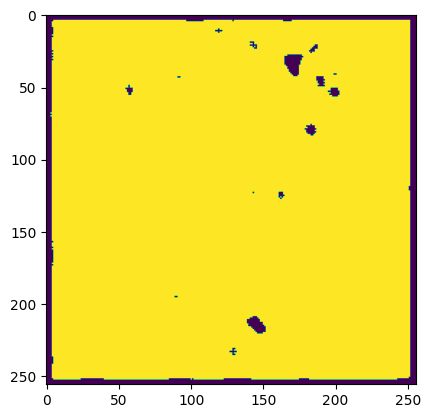

In [34]:
test_images_dir = 'QBAM_DNNS/Abs Test Images'
test_labels_dir = 'QBAM_DNNS/Abs Test Label Images'
transform = transforms.Compose([
    transforms.ToTensor(),
])
test_dataset = SegmentationDataset(images_dir=test_images_dir, labels_dir=test_labels_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=10)

def visualize_sample(image, predicted, label):
    image = image.squeeze()
    label = label.squeeze()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(predicted, cmap='gray')
    ax[1].set_title('Predicted Label')
    ax[2].imshow(label, cmap='gray')
    ax[2].set_title('True Label')
    plt.show()

# Load the best model
model.load_state_dict(torch.load('final_segment_model.pth'))
model.eval()

# Visualization of one sample
sample_visualized = False

total, correct = 0, 0

for batch in tqdm(test_loader, desc='Testing'):
    images, labels = batch

    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    predicted = torch.sigmoid(outputs) > 0.76

    total += labels.nelement()
    correct += (predicted == labels).sum().item()

    # if not sample_visualized:
    show_pred = predicted[0].squeeze().cpu().numpy()
    out = Image.fromarray(show_pred)
    out.save('predicted.png')

    plt.imshow(show_pred)  
    plt.savefig('my_image.png')
    
    #visualize_sample(images[0], show_pred, labels[0])


accuracy = correct / total
print(f'Test Accuracy: {correct}/{total} {accuracy:.4f}')